In [1]:
import random

import numpy as np

from math import sqrt, log

from GCN import *

In [2]:
### Edge List Implementation

class MaxSetState:
    def __init__(self, data, state = None):
        self.data = data
        self.node_weights = data["x"]
        self.edge_index = data["edge_index"]
        
        # number of total nodes in original graph
        self.num_nodes = len(data["x"])
        if state is None:
            
            self.state = np.ones(self.num_nodes, dtype=bool)
        else:
            self.state = state
        
    def clone(self):
        return MaxSetState(self.data, self.state.copy())

    def step(self, action):
        assert self.state[action] == 1
        
        edges = self.edge_index.transpose()
        # Get all the neighbors of node action
        removal = edges[edges[:, 0] == action][:, 1]
        
        # Create mask to remove node action and its neighbors
        mask = np.zeros(self.num_nodes, dtype=bool)
        mask[removal] = 1
        mask[action] = 1
        
        # Perform mask
        new_state = self.state & (~mask)
        reward = self.node_weights[action]
        return MaxSetState(self.data, new_state), reward
    
    def getNeighbors(self, node):
        edges = self.edge_index.transpose()
        # Get all the neighbors of node action
        neighbors = edges[edges[:, 0] == node][:, 1]
        return neighbors

    def actions(self):
        return list(np.flatnonzero(self.state))

    def sample_action(self):
        return random.choice(self.actions())

    def get_edgelist(self):
        new_edges = []
        for e in self.edge_index:
            if self.state[e[0]] == 1 or self.state[e[1]] == 1:
                new_edges.append(e)
        return np.array(new_edges)

    def score(self):
        assert not self.state.any()
        return 0
    def __repr__(self):
        return str(self.state)


In [3]:
class Node:
    def __init__(self, state: MaxSetState, action = None, parent = None):
        # The action that led to this state, and a reference to the parent
        self.action = action
        self.parentNode = parent

        # Statistics
        self.totalScore = 0
        self.visits = 1

        # Children of node
        self.childNodes = []
        self.untriedActions = state.actions()

    def select_child(self):
        upper_confidence = {c: c.totalScore/c.visits + sqrt(4 * log(self.visits)/c.visits) for c in self.childNodes}
        return max(upper_confidence, key=upper_confidence.get)

    def addChild(self, state, action):
        n = Node(state, action, self)
        self.untriedActions.remove(action)
        self.childNodes.append(n)
        return n

    def update(self, score):
        self.visits += 1
        self.totalScore += score

    def __repr__(self):
        return "[A: {0} S/V: {1:.2f}/{2} AR: {4:.2f} U: {3}]".format(self.action, self.totalScore, self.visits - 1, self.untriedActions, self.totalScore / self.visits)

    def treeToString(self, level = 0):
        s = '\t' * level + "" + str(self) + "\n"
        for c in self.childNodes:
            s += c.treeToString(level + 1)
        return s

In [4]:
def search(root: MaxSetState, itermax, verbose):

    rootnode = Node(root)

    for i in range(itermax):
        if (verbose == 2): print(rootnode.treeToString(0))
        node = rootnode
        state = root.clone()
        # Selection
        while node.untriedActions == [] and node.childNodes != []:
            node = node.select_child()
            state, reward = state.step(node.action)

        # Expansion
        if node.untriedActions != []:
            a = random.choice(node.untriedActions)
            if (verbose == 2):
                print("Taking action: " + str(a))
            state, reward = state.step(a)
            node = node.addChild(state, a)

        # Simulation
        if (verbose == 2):
            print("Starting State: " + str(state))
        score = 0
        while state.actions() != []:
            sampled_action = state.sample_action()
            state, reward = state.step(sampled_action)
            score += reward
            if (verbose == 2):
                print("Simulating Action: " + str(sampled_action))
                print("Simulating Reward: " + str(reward))
                print("Next State: " + str(state))
        # Backpropagate

        while node.action != None:
            score += state.node_weights[node.action]
            node.update(score)
            if (verbose == 2):
                print("Node Weights: " + str(state.node_weights))
                print("Action: " + str(node.action))
                print("Reward Value: " + str(state.node_weights[node.action]))
            node = node.parentNode
        
    if (verbose and verbose != 2): print(rootnode.treeToString(0))

    actions = {c.action: c.visits for c in rootnode.childNodes}
    return sorted(list(actions.keys()), key=actions.get, reverse=True)

In [18]:
import matplotlib.pyplot as plt

visualize = MaxIndDataset('data/weighted_med')

ID = 4
test_graph = visualize[ID]

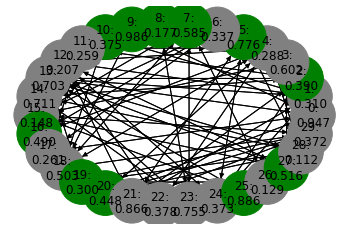

In [19]:
draw_entry(test_graph)

In [20]:
# Debug Search
test_data = {k: np.round(v.data.numpy(), 3) for k, v in iter(test_graph)}
target = sum(test_data['x'][test_data['y'].astype(bool)])
current = MaxSetState(data=test_data)
result = search(current, 100, 2)

[A: None S/V: 0.00/0 AR: 0.00 U: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]

Taking action: 1
Starting State: [ True False  True  True  True  True False  True  True  True False  True
 False False  True  True  True  True  True  True  True False  True  True
 False  True  True False  True False]
Simulating Action: 22
Simulating Reward: 0.378
Next State: [ True False  True  True False  True False  True  True  True False  True
 False False  True  True  True False  True  True  True False False  True
 False False  True False  True False]
Simulating Action: 19
Simulating Reward: 0.3
Next State: [ True False  True  True False  True False  True  True  True False  True
 False False False  True  True False  True False  True False False  True
 False False False False False False]
Simulating Action: 11
Simulating Reward: 0.259
Next State: [ True False False  True False  True False  True  True False False False
 False False False  T

In [12]:
%timeit current.step(0)

8.9 µs ± 126 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [21]:
def random_rollout(data):
    score = 0
    state = MaxSetState(data)
    while state.actions() != []:
        state, reward = state.step(state.sample_action())
        score += reward
    return score

def random_rollout_avg(data, rand_trials):
    tot_rand_score = 0
    for i in range(rand_trials):
        tot_rand_score += random_rollout(data)
    rand_score = tot_rand_score / rand_trials
    return rand_score

def random_rollout_max(data, rand_trials):
    max_rand_score = 0
    for i in range(rand_trials):
        max_rand_score = max(max_rand_score, random_rollout(data))
    return max_rand_score

In [23]:
def searchTester():
    for ID in range(20):
        test_graph = visualize[ID]
        tot_score = 0
        max_tot_score = 0
        trials = 5

        test_data = {k: np.round(v.data.numpy(), 3) for k, v in iter(test_graph)}

        target = sum(test_data['x'][test_data['y'].astype(bool)])
        for i in range(trials):
            current = MaxSetState(data=test_data)
            score = 0
            action = "None"
            reward = 0
            chosen = []
            while current.actions() != []:
                result = search(current, 10000, False)
                current, r = current.step(result[0])
                # print("Action: {0} Reward: {1:.3f} Results: {2}".format(action, reward, result))
                action = result[0]
                score += r
                reward = r
                chosen.append(action)
            tot_score += score

            optimal = np.flatnonzero(test_data['y'])
    #         print("Chosen: {0}".format(sorted(chosen)))
    #         print("Optimal: {0}".format(sorted(optimal)))
    #         print("Action: {0} Score: {1:.3f}".format(action, score))
    #         print("Target: {0:.3f}".format(target))
    #         print("--------------------")
            max_tot_score = max(max_tot_score, score)
        rand_avg_baseline = random_rollout_avg(test_data, 1000)
        rand_max_baseline = random_rollout_max(test_data, 1000)
        print("ID[{0}]: Target: {1:.3f} Algo Avg Score: {2:.3f}\t Algo Max Score: {3:.3f}\t Rand Avg Score: {4:.3f} Rand Max Score: {5:.3f}".format(ID, target, (tot_score / trials), max_tot_score, rand_avg_baseline, rand_max_baseline))



ID[0]: Target: 7.437 Algo Avg Score: 7.178	 Algo Max Score: 7.252	 Rand Avg Score: 4.994 Rand Max Score: 7.437
ID[1]: Target: 6.895 Algo Avg Score: 6.394	 Algo Max Score: 6.650	 Rand Avg Score: 4.736 Rand Max Score: 6.895
ID[2]: Target: 5.418 Algo Avg Score: 5.378	 Algo Max Score: 5.418	 Rand Avg Score: 4.301 Rand Max Score: 5.418
ID[3]: Target: 5.660 Algo Avg Score: 5.510	 Algo Max Score: 5.660	 Rand Avg Score: 3.854 Rand Max Score: 5.660
ID[4]: Target: 5.929 Algo Avg Score: 5.835	 Algo Max Score: 5.929	 Rand Avg Score: 4.252 Rand Max Score: 5.929
ID[5]: Target: 6.307 Algo Avg Score: 6.168	 Algo Max Score: 6.267	 Rand Avg Score: 4.822 Rand Max Score: 6.307
ID[6]: Target: 5.194 Algo Avg Score: 5.045	 Algo Max Score: 5.194	 Rand Avg Score: 3.822 Rand Max Score: 5.194
ID[7]: Target: 8.059 Algo Avg Score: 7.769	 Algo Max Score: 8.059	 Rand Avg Score: 5.238 Rand Max Score: 8.059
ID[8]: Target: 6.217 Algo Avg Score: 5.781	 Algo Max Score: 6.217	 Rand Avg Score: 4.194 Rand Max Score: 5.961
I

In [ ]:
searchTester()

In [24]:
import cProfile
cProfile.run('searchTester()')

         34157443 function calls in 34.864 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   162389    0.125    0.000    0.457    0.000 <ipython-input-2-d0aba86c4c4b>:17(clone)
  1111696   12.788    0.000   15.221    0.000 <ipython-input-2-d0aba86c4c4b>:20(step)
  1274086    0.856    0.000    1.006    0.000 <ipython-input-2-d0aba86c4c4b>:4(__init__)
   677052    1.711    0.000    4.430    0.000 <ipython-input-2-d0aba86c4c4b>:43(actions)
   217991    0.184    0.000    1.648    0.000 <ipython-input-2-d0aba86c4c4b>:46(sample_action)
        1    0.000    0.000   34.864   34.864 <ipython-input-23-c4b89d6d1255>:1(searchTester)
        1    0.000    0.000    0.000    0.000 <ipython-input-23-c4b89d6d1255>:8(<dictcomp>)
   815042    0.627    0.000    9.239    0.000 <ipython-input-3-76847ac81d7f>:15(select_child)
   815042    6.015    0.000    7.525    0.000 <ipython-input-3-76847ac81d7f>:16(<dictcomp>)
    78647    0.096    0.000 

KeyboardInterrupt: 

In [ ]:
draw_entry(test_graph)

In [ ]:
current = MaxSetState(data=test_data)

In [ ]:
current.getNeighbors(16)